# Save model for Tensorflow Serving
## Lifted mostly from https://www.tensorflow.org/tfx/serving/tutorials/Serving_REST_simple

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import subprocess

print(tf.__version__)

1.13.1


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


In [3]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model.summary()

testing = False
epochs = 5

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
60000/60000 [==============================] - 17s 287us/sample - loss: 0.5489 - acc: 0.8104
Epoch 2/5
60000/60000 [==============================] - 16s 262us/sample - loss: 0.4205 - acc: 0.8527
Epoch 3/5
60000/60000 [==============================] - 16s 267us/sample - loss: 0.3899 - acc: 0.8633
Epoch 4/5
60000/60000

In [4]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir() + '/mnist'
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.simple_save(
    keras.backend.get_session(),
    export_path,
    inputs={'input_image': model.input},
    outputs={t.name:t for t in model.outputs})

export_path = /tmp/mnist/1


Already saved a model, cleaning up

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/mnist/1/saved_model.pb


## Test
View image

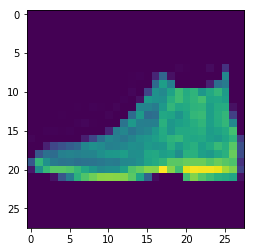

In [5]:
pic = test_images[0:1]
plt.imshow(pic.reshape(28,28))

Save image as image.json

In [6]:
data = json.dumps({"signature_name": "serving_default", "instances": pic.tolist()})
with open('image.json', 'w') as f:
  f.write(data)

Move model to serving directory, then check<br>
curl -X POST -H "Content-Type: application/json" -d @image.json http://loadbalancerIP:assginedPORT/v1/models/mnist:predict
<br>Result:<br>
{
    "predictions": [[1.65433e-06, 1.64561e-07, 3.53323e-06, 2.86745e-06, 6.96201e-06, 0.0273952, 2.95962e-05, 0.157299, 0.00583552, 0.809425]
    ]
}
<br> Therefore, the last element is most likely (Ankle boot).